In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline

# 1. Reading the training and test data, dropping id column and seperating out the Target variable SalePrice

In [4]:
housetraindf = pd.read_csv('train.csv')
housetestdf = pd.read_csv('test.csv')
train_id = housetraindf.Id
test_id = housetestdf.Id
target = housetraindf.SalePrice
target = target.apply(np.log1p,1)
housetraindf.drop("Id",1,inplace=True)
housetestdf.drop("Id",1,inplace=True)
housetraindf.drop("SalePrice",1,inplace= True)
trainmoddf = pd.concat([housetraindf,housetestdf])

# 2. MSSubCLass and MoSold are both numeric field but should be categorical. So seperating them out before checking skewness on numeric_types. Apply log1p for all skewed data greater than .75

In [5]:
trainmoddf.MSSubClass = trainmoddf.MSSubClass.astype("object")
trainmoddf.MoSold = trainmoddf.MoSold.astype("object")

In [6]:
numeric_types = trainmoddf.dtypes[trainmoddf.dtypes != "object"].index
skewd = trainmoddf[numeric_types].columns[trainmoddf[numeric_types].skew() > 0.75]
data_log = trainmoddf[skewd].apply(np.log1p,1)
trainmoddf[skewd] = data_log
trainmoddf[numeric_types] = trainmoddf[numeric_types].fillna(trainmoddf[numeric_types].median())

# 3. Ordering Cateforical features wherever applicable

In [7]:
# Ordering Categorical features
trainmoddf.Street = trainmoddf.Street.replace(["Grvl","Pave"],[1,2])
trainmoddf.Alley = trainmoddf.Alley.replace([np.nan,"Grvl","Pave"],[0,1,2])
trainmoddf.LotShape = trainmoddf.LotShape.replace(["IR3","IR2","IR1","Reg"],[1,2,3,4])
trainmoddf.LandSlope = trainmoddf.LandSlope.replace(["Sev","Mod","Gtl"],[1,2,3])
trainmoddf.ExterQual = trainmoddf.ExterQual.replace(["Po","Fa","TA","Gd","Ex"],[1,2,3,4,5])
trainmoddf.ExterCond = trainmoddf.ExterCond.replace(["Po","Fa","TA","Gd","Ex"],[1,2,3,4,5])
trainmoddf.BsmtQual = trainmoddf.BsmtQual.replace([np.nan,"Po","Fa","TA","Gd","Ex"],[0,1,2,3,4,5])
trainmoddf.BsmtCond = trainmoddf.BsmtCond.replace([np.nan,"Po","Fa","TA","Gd","Ex"],[0,1,2,3,4,5])
trainmoddf.BsmtExposure = trainmoddf.BsmtExposure.replace([np.nan,"No","Mn","Av","Gd"],[0,1,2,3,4])
trainmoddf.BsmtFinType1 = trainmoddf.BsmtFinType1.replace([np.nan,"Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
                                              [0,1,2,3,4,5,6])
trainmoddf.BsmtFinType2 = trainmoddf.BsmtFinType2.replace([np.nan,"Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
                                              [0,1,2,3,4,5,6])
trainmoddf.HeatingQC = trainmoddf.HeatingQC.replace(["Po","Fa","TA","Gd","Ex"],[1,2,3,4,5])
trainmoddf.CentralAir = trainmoddf.CentralAir.replace(['N','Y'],[0,1])
trainmoddf.KitchenQual = trainmoddf.KitchenQual.replace(["Po","Fa","TA","Gd","Ex"],[1,2,3,4,5])
trainmoddf.Functional = trainmoddf.Functional.replace([np.nan,"Sal","Sev","Maj2","Maj1","Mod","Min2","Min1","Typ"],
                                         [0,1,2,3,4,5,6,7,8])
trainmoddf.FireplaceQu = trainmoddf.FireplaceQu.replace([np.nan,"Po","Fa","TA","Gd","Ex"],[0,1,2,3,4,5])
trainmoddf.GarageFinish = trainmoddf.GarageFinish.replace([np.nan,"Unf","RFn","Fin"],[0,1,2,3])
trainmoddf.GarageQual = trainmoddf.GarageQual.replace([np.nan,"Po","Fa","TA","Gd","Ex"],[0,1,2,3,4,5])
trainmoddf.GarageCond = trainmoddf.GarageCond.replace([np.nan,"Po","Fa","TA","Gd","Ex"],[0,1,2,3,4,5])
trainmoddf.PavedDrive = trainmoddf.PavedDrive.replace(["N","P","Y"],[0,1,2])
trainmoddf.Fence = trainmoddf.Fence.replace([np.nan,"MnWw","GdWo","MnPrv","GdPrv"],[0,1,2,3,4])
trainmoddf.GarageType = trainmoddf.GarageType.replace(np.nan,"No Garage")
trainmoddf.MiscFeature = trainmoddf.MiscFeature.replace(np.nan,"No Feature")
trainmoddf.PoolQC = trainmoddf.PoolQC.replace([np.nan,"Fa","TA","Gd","Ex"],[0,1,2,3,4])

# 4. Get dummies for remaining categorical data

In [8]:
## Get dummies of the categorical data
dummy = pd.get_dummies(trainmoddf)
print(dummy.shape)
dummy.reset_index(inplace=True)
dummy.drop("index",1,inplace=True)

(2919, 248)


# 5. Splitting train and test data

In [9]:
train_dummy = dummy.iloc[0:len(housetraindf)]
test_dummy = dummy.iloc[len(housetraindf):]

print(housetraindf.shape)
print(housetestdf.shape)
print(train_dummy.shape)
print(test_dummy.shape)

(1460, 79)
(1459, 79)
(1460, 248)
(1459, 248)


# 6. Outlier Removal

In [10]:
row_name = housetraindf.GrLivArea[housetraindf.GrLivArea > 4000].index
train_dummy.drop(train_dummy.index[row_name],inplace=True)
target.drop(target.index[row_name],inplace=True)
test_dummy.fillna(0,inplace=True)

# 7. Split Train and Test

In [11]:
train = train_dummy
test = test_dummy
target = target
test_id = pd.read_csv('test.csv',header=0,usecols=["Id"])
# test_id = pd.read_csv("input/test.csv",header=0,usecols=["Id"])
x_train,x_val,y_target,y_val = train_test_split(train,target,random_state = 0)

# 8. Run Grid Search for hyper parameter tuning 

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.pipeline import make_pipeline

alpha = np.array([0.02, 0.024, 0.025, 0.026, 0.03,0.1,1,10,100,290,500,100])
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(x_train,y_target)

ridge_model = Ridge()
ridgegrid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alpha))
ridgegrid.fit(x_train,y_target)
lasso_model = Lasso()
lassogrid = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=alpha))
lassogrid.fit(x_train,y_target)
elastic_model = elastic_net
elasticgrid = GridSearchCV(estimator=elastic_model, param_grid=dict(alpha=alpha, l1_ratio=l1_ratio))
elasticgrid.fit(x_train,y_target)
desisiontree_model = make_pipeline(tree.DecisionTreeRegressor())
depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]
param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]
decisiontreegrid= GridSearchCV(estimator=desisiontree_model, param_grid=param_grid,)
decisiontreegrid = decisiontreegrid.fit(x_train, y_target)


# print(grid)
# # summarize the results of the grid search
# print(grid.best_score_)
print("Ridge Best Estimator ")
print(ridgegrid.best_estimator_)
print("Lasso Best Estimator " )
print(lassogrid.best_estimator_)
print("ElasticNet Best Estimator " )
print(elasticgrid.best_estimator_)
print("Decision Tree Best Estimator " )
print(decisiontreegrid.best_estimator_)

Ridge Best Estimator 
Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Lasso Best Estimator 
Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
ElasticNet Best Estimator 
ElasticNet(alpha=0.02, copy_X=True, fit_intercept=True, l1_ratio=0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Decision Tree Best Estimator 
Pipeline(memory=None,
         steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=7, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
          

# 9. Run all model with the best estimator got from Grid Search CV

In [13]:
## All the algorithms that I ran with best hyper tuning parameters from Grid Search CV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.pipeline import make_pipeline

model_name = ["Linear","Ridge","Lasso","Elastic","Bagging","Adaboost","Decision Tree","Gradient Boosting"]
model_l = []
linear = LinearRegression().fit(x_train,y_target).predict(x_val)
ridge = Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=0, solver='cholesky', tol=0.001).fit(x_train,y_target).predict(x_val)
lasso = Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False).fit(x_train,y_target).predict(x_val)
elastic = ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False).fit(x_train,y_target).predict(x_val)
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=7, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=0,
                                       splitter='best')).fit(x_train,y_target).predict(x_val)
boosting = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=7, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=0,
                                       splitter='best')).fit(x_train,y_target).predict(x_val)
decision = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=7, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=0,
                                       splitter='best').fit(x_train,y_target).predict(x_val)
Gradient = GradientBoostingRegressor(n_estimators=120,learning_rate=0.09,max_depth=5,max_features=68,random_state=0).fit(x_train,y_target).predict(x_val)
model_l.append(linear)
model_l.append(ridge),
model_l.append(lasso)
model_l.append(elastic)
model_l.append(bagging)
model_l.append(boosting)
model_l.append(decision)
model_l.append(Gradient)

# 10. Calculate the RMSE for all the predicted models

In [14]:

def accuracy_report(name, predicted,original):
    error = np.sqrt((mean_squared_error(predicted,original)))
    print(name, "  Root Mean Square Error ","--", error)
    return error


acc_l= []
for i in range(len(model_l)):
    acc = accuracy_report(model_name[i],model_l[i],y_val)
    acc_l.append(acc)

Linear   Root Mean Square Error  -- 0.11625304821940145
Ridge   Root Mean Square Error  -- 0.10970645564090685
Lasso   Root Mean Square Error  -- 0.14890206371241946
Elastic   Root Mean Square Error  -- 0.10656895878641695
Bagging   Root Mean Square Error  -- 0.13850429043317955
Adaboost   Root Mean Square Error  -- 0.1211984174817365
Decision Tree   Root Mean Square Error  -- 0.18155729320575034
Gradient Boosting   Root Mean Square Error  -- 0.11177915678293805


# 11. Plot the RMSE across each models as barplot for better representation.

Text(0.5, 1.0, "Algorithm's Root Mean Squared Error")

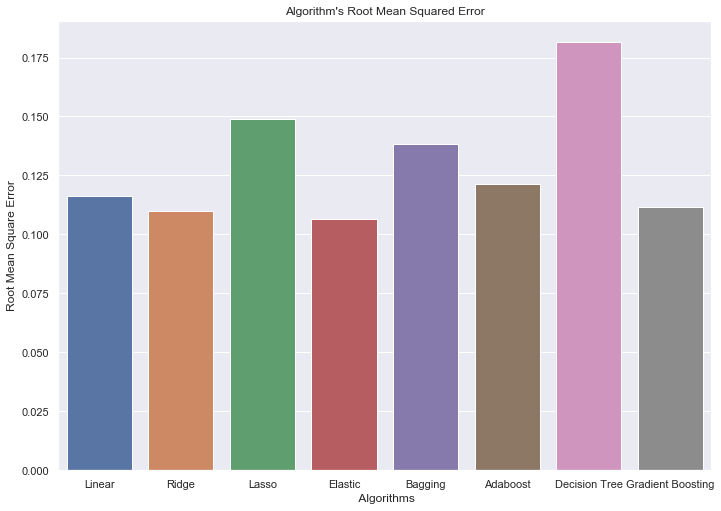

In [19]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
algorithm = sns.barplot(x = model_name,y=acc_l)
algorithm.set(xlabel=" Algorithms",ylabel= "Root Mean Square Error")
algorithm.set_title("Algorithm's Root Mean Squared Error")

# 12. Calculate R2 for all the predicted models

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

def R2_report(name, original,predicted):
#     error = np.sqrt((mean_squared_error(predicted,original)))
    r2 = r2_score(original, predicted)
    print(name, "  R2 Value ","--", r2)
    return r2


scr_l= []
for i in range(len(model_l)):
    scr = R2_report(model_name[i],y_val,model_l[i])
    scr_l.append(scr*100)

Linear   R2 Value  -- 0.913925573184549
Ridge   R2 Value  -- 0.9233468847732251
Lasso   R2 Value  -- 0.8587895376932877
Elastic   R2 Value  -- 0.9276685974796877
Bagging   R2 Value  -- 0.877822314295904
Adaboost   R2 Value  -- 0.9064466508913507
Decision Tree   R2 Value  -- 0.7900611375334884
Gradient Boosting   R2 Value  -- 0.9204230848679789


# 13. Plot the R2 across each models as barplot for better representation

Text(0.5, 1.0, "Algorithm's R2")

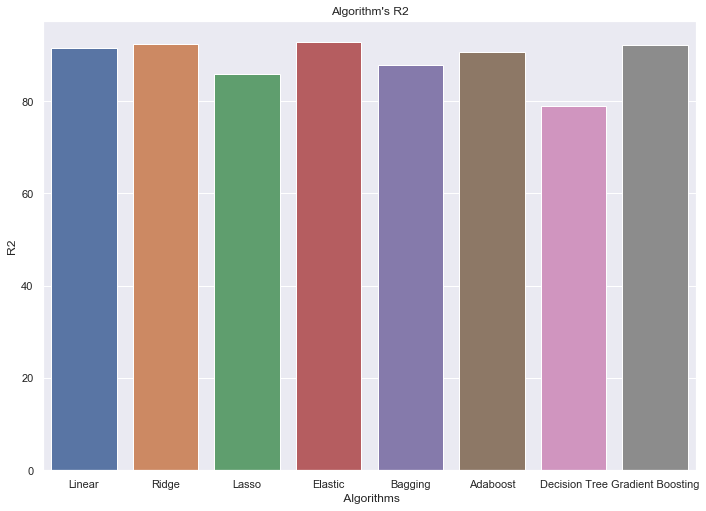

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
algorithm = sns.barplot(x = model_name,y=scr_l)
algorithm.set(xlabel=" Algorithms",ylabel= "R2")
algorithm.set_title("Algorithm's R2")